In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 13.24 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign


dev.txt  test.txt  train.txt


In [ ]:
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import string
from tensorflow.keras.layers import TextVectorization
import random

In [ ]:
filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
#Preprocess data
def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()


In [ ]:
train_lines=get_lines(filenames[1])
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_lines(filename):
  abstract_samples=[]
  abstract_lines=""
  input_lines=get_lines(filename)
  for line in input_lines:
    if line.startswith("###"):
      abstract_id=line
      abstract_lines=""
    elif line.isspace():
      abstract_line_split=abstract_lines.splitlines()
      for abstract_line_no,abstract_line in enumerate(abstract_line_split):
        line_data={}
        split_sentence=abstract_line.split("\t")
        label=split_sentence[0]
        sentence=split_sentence[1:]
        line_data["target"]=label
        line_data["text"]=str(sentence).lower()
        line_data["line_number"]=abstract_line_no
        line_data["total_lines"]=len(abstract_line_split)
        abstract_samples.append(line_data)
    else:
      abstract_lines+=line

  return abstract_samples

In [ ]:
train_samples=preprocess_text_lines(data_dir+"train.txt")
val_samples=preprocess_text_lines(data_dir+"dev.txt")
test_samples=preprocess_text_lines(data_dir+"test.txt")

In [ ]:
train_samples[:2]

[{'target': 'OBJECTIVE',
  'text': "['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .']",
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': "['a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .']",
  'line_number': 1,
  'total_lines': 12}]

In [ ]:

train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,['to investigate the efficacy of @ weeks of da...,0,12
1,METHODS,['a total of @ patients with primary knee oa w...,1,12
2,METHODS,['outcome measures included pain reduction and...,2,12
3,METHODS,['pain was assessed using the visual analog pa...,3,12
4,METHODS,['secondary outcome measures included the west...,4,12
...,...,...,...,...
180035,RESULTS,['for the absolute change in percent atheroma ...,7,12
180036,RESULTS,"['for pav , a significantly greater percentage...",8,12
180037,RESULTS,['both strategies had acceptable side effect p...,9,12
180038,CONCLUSIONS,"['compared with standard statin monotherapy , ...",10,12


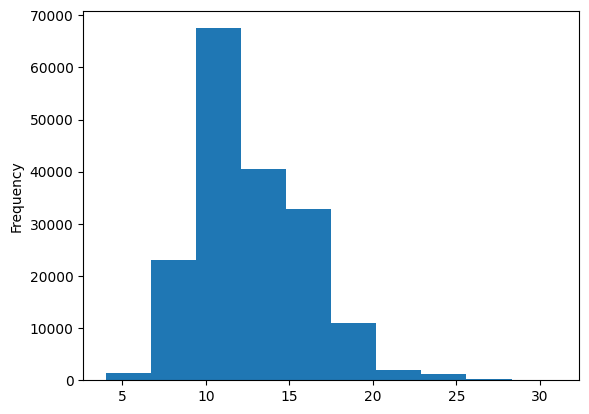

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()
train_sentences[:10]

["['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .']",
 "['a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .']",
 "['outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']",
 "['pain was assessed using the visual analog pain scale ( @-@ mm ) .']",
 "['secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']",
 "['serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .'

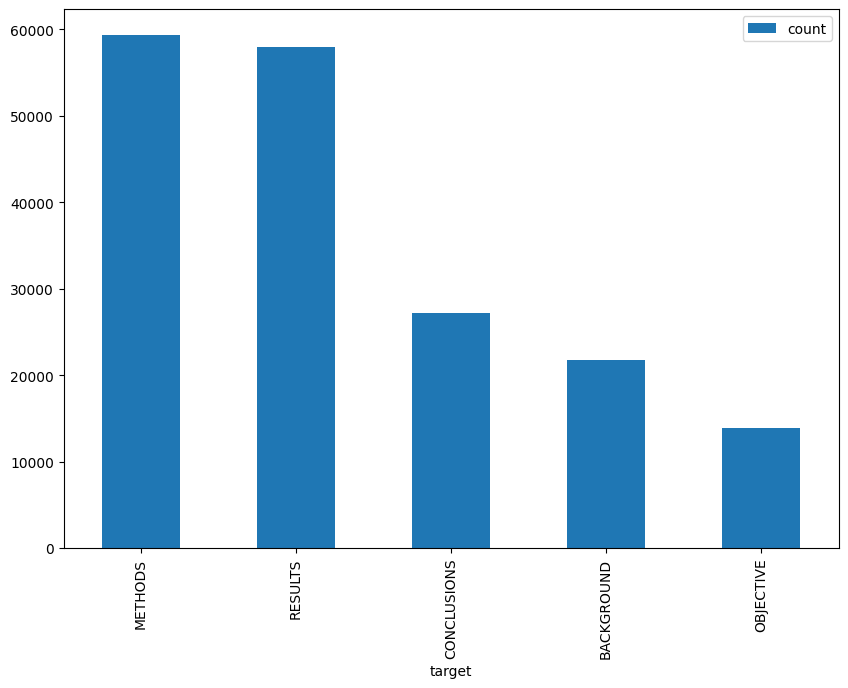

In [ ]:
#visualising the no of sentences per label
methods=train_df["target"].value_counts()
methods=methods.transpose()
plot=pd.DataFrame(methods).plot(kind="bar",figsize=(10,7))

In [ ]:
##label sequence optimization layer
#ANY ENGINEER FEATURE SHOULD BE AVAILABLE AT RUNTIME

#input =seq of probability vectors from label predictionlayer
#outputs= seq of labels assigned to a token
df=pd.DataFrame(train_df["target"],train_df["line_number"])
df_2=df.groupby("target").get_group("OBJECTIVE")
print(df_2)

                target
line_number           
0            OBJECTIVE
0            OBJECTIVE
0            OBJECTIVE
14           OBJECTIVE
0            OBJECTIVE
...                ...
0            OBJECTIVE
0            OBJECTIVE
0            OBJECTIVE
0            OBJECTIVE
0            OBJECTIVE

[19696 rows x 1 columns]


In [ ]:
#ANY ENGINEER FEATURE SHOULD BE AVAILABLE AT RUNTIME
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


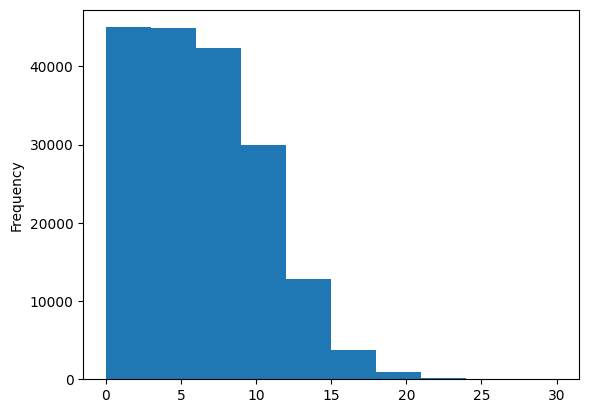

In [ ]:
#check distribution
train_df.line_number.plot(kind="hist");

In [ ]:
#one hot encoded
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10]


<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
line_no_percentile=np.percentile(train_df["line_number"],95)
print(line_no_percentile)


13.0


In [ ]:
train_df["total_lines"].value_counts()

,count
total_lines,
12,24468
11,23639
13,22113
10,19400
14,18438
15,14610
9,12285
16,10768
8,7464


19.0


<Axes: ylabel='Frequency'>

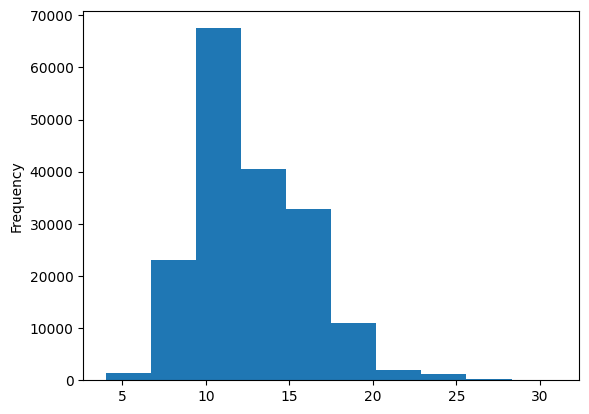

In [ ]:
no=np.percentile(train_df["total_lines"],95)
print(no)
train_df.total_lines.plot(kind="hist")

In [ ]:
total_line_percentile=np.percentile(train_df["total_lines"],97)
total_line_percentile

20.0

In [ ]:
train_total_lines=tf.one_hot(train_df["total_lines"].to_numpy(),depth=total_line_percentile)
val_total_lines=tf.one_hot(val_df["total_lines"].to_numpy(),depth=total_line_percentile)
test_total_lines=tf.one_hot(test_df["total_lines"].to_numpy(),depth=total_line_percentile)
train_line_numbers_one_hot[0].shape


TensorShape([15])

In [ ]:
train_total_lines[0].shape

TensorShape([20])

In [ ]:
##Character embedding
def split_chars(text):
  return " ".join(list(text))
train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]
train_chars[:3]

["[ ' t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   . ' ]",
 "[ ' a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   . ' ]",
 "[ ' o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o 

In [ ]:
char_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

153.36626305265497

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([   5.        ,  202.85714286,  400.71428571,  598.57142857,
         796.42857143,  994.28571429, 1192.14285714, 1390.        ]),
 <BarContainer object of 7 artists>)

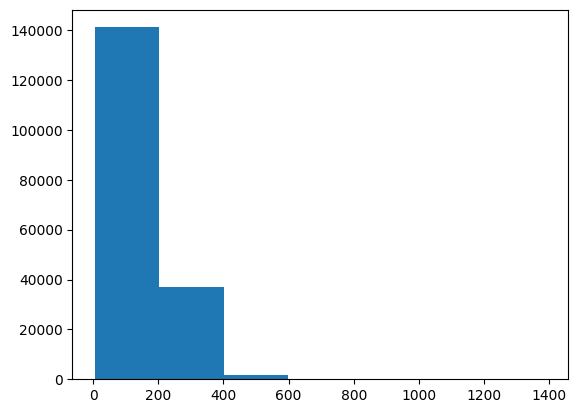

In [ ]:
plt.hist(char_lens,bins=7)

In [ ]:
#95 percent of alphabets
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

294

In [ ]:
alphabet=string.ascii_lowercase+string.digits
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789'

In [ ]:
#create char-level token vectorizer instance
NUM_CHAR_TOKENS=len(alphabet)+2 #add 2 for space and OOV token (out of vocab ,"[UNK]")
char_vectorizer =TextVectorization(max_tokens=NUM_CHAR_TOKENS,output_sequence_length=output_seq_char_len)
random_chars=random.choice(train_chars)
#adapting the vectorizer
char_vectorizer.adapt(train_chars)
print(f"charified text:\n {random_chars}")
print(f"5 most common character  {char_vectorizer(random_chars)[:5]}")
print(f"5 least common character {char_vectorizer(random_chars)[-5:]}")

charified text:
 [ ' a d h d   i s   p r e v a l e n t   i n   a d u l t s   a n d   f r e q u e n t l y   a s s o c i a t e d   w i t h   i m p a i r m e n t   a n d   d i s t r e s s   . ' ]
5 most common character  [ 5 10 13 10  4]
5 least common character [0 0 0 0 0]


In [ ]:
char_vocab=char_vectorizer.get_vocabulary()

char_embed=layers.Embedding(input_dim=len(char_vocab),output_dim=25,mask_zero=True,input_length=output_seq_char_len,name="char_embed")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
print(f"charified text :\n {random_chars}")
char_embed_example=char_embed(char_vectorizer(random_chars))
print(f"embedded chars  after vectorization and embedding {char_embed_example}")
print(f"character embedding shape: {char_embed_example.shape}")

charified text :
 [ ' a d h d   i s   p r e v a l e n t   i n   a d u l t s   a n d   f r e q u e n t l y   a s s o c i a t e d   w i t h   i m p a i r m e n t   a n d   d i s t r e s s   . ' ]
embedded chars  after vectorization and embedding [[-0.004609   -0.0067184   0.03289372 ... -0.01357619  0.04154307
   0.0459719 ]
 [ 0.02969554  0.02024153 -0.03057296 ...  0.00937136  0.00688083
   0.02254181]
 [-0.04711924  0.00172396  0.00699054 ... -0.02936794 -0.0259029
  -0.00133871]
 ...
 [ 0.01574922  0.04411513  0.0314138  ...  0.00859142 -0.04077461
   0.02007086]
 [ 0.01574922  0.04411513  0.0314138  ...  0.00859142 -0.04077461
   0.02007086]
 [ 0.01574922  0.04411513  0.0314138  ...  0.00859142 -0.04077461
   0.02007086]]
character embedding shape: (294, 25)


In [ ]:
#encoding the labels
from sklearn.preprocessing import LabelEncoder
label_encode=LabelEncoder()
train_labels_encoded=label_encode.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encode.fit_transform(val_df["target"].to_numpy())
test_labels_encoded=label_encode.fit_transform(test_df["target"].to_numpy())

In [ ]:
num_classes=len(label_encode.classes_)
class_names=label_encode.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
import tensorflow_hub as hub
from tensorflow import keras
use_embedding=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",input_shape=[],trainable=False,dtype="string",name="universal_encoder")
@keras.saving.register_keras_serializable(package="my_package", name="custom_fn")
def use_embed(inputs):
  return use_embedding(inputs)
@keras.saving.register_keras_serializable(package="MyLayers")
class embed_layer(layers.Layer):
  def __init__(self, **kwargs):
      super(embed_layer, self).__init__(**kwargs)
  def call(self,inputs):
    return use_embedding(inputs)



In [ ]:
###Building a tribrid model
token_input=layers.Input(shape=(),dtype=tf.string,name="token_input")
token_embeddings=embed_layer()(token_input)
token_output=layers.Dense(128,activation="softmax")(token_embeddings)
token_model=tf.keras.Model(inputs=token_input,outputs=token_output)

#char model
char_input=layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors=char_vectorizer(char_input)
char_embeddings=char_embed(char_vectors)
#bi directional lstm
char_output=layers.Bidirectional(layers.LSTM(32,activation="softmax"))(char_embeddings)
char_model=tf.keras.Model(inputs=char_input,outputs=char_output)

#positional embedding
line_number_input=layers.Input(shape=(15,),dtype=tf.int32,name="line_number_input")
#line_number_embeddings=layers.Embedding(input_dim=15,output_dim=128)(line_number_input)
line_number_output=tf.keras.layers.Dense(32,activation="relu")(line_number_input)
line_number_model=tf.keras.Model(inputs=line_number_input,outputs=line_number_output)

#total_lines
total_lines_input=layers.Input(shape=train_total_lines[0].shape,dtype=tf.int32,name="total_lines_input")
total_embeddings=layers.Dense(32,activation="relu")(total_lines_input)
total_line_model=tf.keras.Model(inputs=total_lines_input,outputs=total_embeddings)

#combine token and char embeddings
combined_embeddings=layers.Concatenate(name="concatenate",axis=1)([token_model.output,char_model.output])

z=layers.Dense(256,activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)
output_layer=layers.Dense(num_classes,activation="softmax")(z)

#TRIBRID EMBEDDINGS
tribrid_embeddings=layers.Concatenate(name="tribrid_embeddings")([line_number_model.output,total_line_model.output,z])
#create output layer
output_layer=layers.Dense(5,activation="softmax")(tribrid_embeddings)

In [ ]:
model_5=tf.keras.Model(inputs=[line_number_model.input,total_line_model.input,token_model.input,char_model.input],outputs=output_layer)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)  # Use sparse=False to get a dense array

# Fit the encoder on the training labels and transform the training data
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))

# Transform the validation and test data using the already-fitted encoder
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Output the one-hot encoded training labels
train_labels_one_hot


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32) #prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32) #prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset.element_spec

((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.string, name=None),
  TensorSpec(shape=(None,), dtype=tf.string, name=None)),
 TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))

In [ ]:
#label smoothing
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
model_5_history=model_5.fit(train_pos_char_token_dataset,steps_per_epoch=int(0.1*len(train_pos_char_token_dataset)),epochs=3)

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 237s 405ms/step - accuracy: 0.4720 - loss: 1.4101
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 212s 378ms/step - accuracy: 0.7514 - loss: 1.0355
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 209s 371ms/step - accuracy: 0.7796 - loss: 1.0079


In [ ]:
model_5.save("skimlit.keras")


In [ ]:
model_5.evaluate(val_pos_char_token_dataset,steps=len(val_pos_char_token_dataset))

945/945 ━━━━━━━━━━━━━━━━━━━━ 84s 87ms/step - accuracy: 0.7924 - loss: 0.9797


[0.9805859327316284, 0.7923341989517212]

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines,
                                                               test_sentences,
                                                               test_chars))
print(f"{len(test_pos_char_token_data)}")
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_encoded)
print(f"{len(test_labels_one_hot)}")

print(f"{len(test_pos_char_token_labels)}")
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32)#.prefetch(tf.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

30135
30135
30135


<_BatchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
preds=model_5.predict(test_pos_char_token_dataset)

595/942 ━━━━━━━━━━━━━━━━━━━━ 36s 106ms/step

KeyboardInterrupt: 

In [ ]:
model_6=tf.keras.models.load_model("skimlit3.keras",custom_objects={"UniversalSentenceEncoderLayer":embed_layer})

In [ ]:
model_6.summary()

In [ ]:
model_6.get_config()

In [ ]:
model_6.evaluate(val_pos_char_token_dataset,steps=len(val_pos_char_token_dataset))

In [ ]:
preds_probs=tf.argmax(preds,axis=1)

In [ ]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_results(y_true,y_pred):
  model_accuracy=accuracy_score(y_true,y_pred)*100
  model_precision,model_recall,model_f1,_=precision_recall_fscore_support(y_true,y_pred,average="weighted")
  return {"accuracy":model_accuracy,"precision":model_precision,"recall":model_recall,"f1":model_f1}

In [ ]:
calculate_results(test_labels_encoded,preds_probs)

In [ ]:
model_5.save_weights("skimlit_weights.weights.h5")

In [ ]:
saved_model=model_5.load_weights("skimlit_weights.weights.h5")

In [ ]:
vals=saved_model.predict(test_pos_char_token_dataset)

In [ ]:
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'embed_layer': embed_layer}):
  model_6=tf.keras.models.load_model("skimlit.h5")

In [ ]:
loaded_model = tf.keras.models.load_model('skimlit.h5', custom_objects={'UniversalSentenceEncoderLayer': embed_layer})
